In [1]:
##连接Spark
import taiji_ide #用于选择spark的版本
taiji_ide.set_spark(version="3.1.2",gaia_id="3527") #导入spark环境，选择spark版本
import os
from pyspark.sql import *

os.environ['GROUP_ID'] = 'g_wxg_wxa_wxa_offline_datamining'
os.environ['GAIA_ID'] = '3527'
session = SparkSession.builder.config('spark.driver.memory', '8g').config('spark.executor.cores', 4).config('spark.executor.memory', '8g').getOrCreate()

Driver Log Write In: /tmp/log/spark-8bbe558e-f598-49c8-9074-9bd158fbd24b.log
TDWHelper Tracking Url : http://tdwhelper.oa.com/resources_pool_status/app/yarn_app_heuristic.php?app_id=application_1695279438085_54646390
Spark UI : http://application.tdw.oa.com:8080/proxy/application_1695279438085_54646390


In [2]:
###
import tensorflow as tf
import logging
import argparse
import sys
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind
## spark 相关包
from commutil import spark_util
from commutil import tdw_util
from pyspark.sql.types import Row
from pytoolkit import TDWSQLProvider, TDWUtil, TDWProvider, TableDesc, TableInfo
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassificationModel,DecisionTreeClassificationModel,GBTClassificationModel,LogisticRegressionModel,LinearSVCModel,NaiveBayesModel
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
import sys
from commutil import spark_util
from commutil import tdw_util
from pytoolkit import TDWSQLProvider, TDWUtil, TDWProvider, TableDesc, TableInfo
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, StringType
from pyspark.sql.functions import col,lit,split
import json
import argparse
import tensorflow as tf
from pyspark.sql import SparkSession
import os
from datetime import datetime, timedelta
from pyspark.sql import functions as F


'''
os.environ['GROUP_ID'] = 'g_wxg_wxplat_wxg_mmbiz_dw'
os.environ['GAIA_ID'] = '3651'
session = SparkSession.builder.config('spark.driver.memory', '16g').config('spark.executor.cores', 8).config('spark.executor.memory', '16g').getOrCreate()
spark = spark_util.session(app_name='dnn_classify')
dw_util = TDWUtil(dbName='wxg_mmbiz_dw')
db_name =  'wxg_mmbiz_dw'
table_name  = 'dwmid_daily_wxapp_short_moive_sample_feature_at' 
pri_parts = '20231111'
sample = tdw_util.read_df(spark, db_name=db_name, table_name=table_name, pri_parts=[pri_parts]).limit(100)
sample.show()
'''

"\nos.environ['GROUP_ID'] = 'g_wxg_wxplat_wxg_mmbiz_dw'\nos.environ['GAIA_ID'] = '3651'\nsession = SparkSession.builder.config('spark.driver.memory', '16g').config('spark.executor.cores', 8).config('spark.executor.memory', '16g').getOrCreate()\nspark = spark_util.session(app_name='dnn_classify')\ndw_util = TDWUtil(dbName='wxg_mmbiz_dw')\ndb_name =  'wxg_mmbiz_dw'\ntable_name  = 'dwmid_daily_wxapp_short_moive_sample_feature_at' \npri_parts = '20231111'\nsample = tdw_util.read_df(spark, db_name=db_name, table_name=table_name, pri_parts=[pri_parts]).limit(100)\nsample.show()\n"

In [71]:
##读取tdw里的分区表
from pytoolkit import TDWSQLProvider
provider = TDWSQLProvider(session, group='tl', db='wxg_mmbiz_dw')
# priParts的分区填写要加上p_, 比如 priParts=['p_20231124']
provider.table('dwmid_daily_wxapp_discover_page_uin_num_label_at').createOrReplaceTempView('dwmid_daily_wxapp_discover_page_uin_num_label_at')
#转为pandas中的df
#仅包含新版发现页的访问
df=session.sql('select * from dwmid_daily_wxapp_discover_page_uin_num_label_at').toPandas()
df.head()
provider.table('res_daily_mmbiz_wxapp_discover_page_main_index_at').createOrReplaceTempView('res_daily_mmbiz_wxapp_discover_page_main_index_at')
#发现页面的新版和旧版的全部
df_all=session.sql('select ds,new_uv,old_uv,all_uv from res_daily_mmbiz_wxapp_discover_page_main_index_at where ds>=20230501').toPandas()
#9月1号新版发现页新用户的后续访问小程序情况
provider.table('dwmid_daily_wxapp_discover_page_uin_retention_at_fix').createOrReplaceTempView('dwmid_daily_wxapp_discover_page_uin_retention_at_fix')
df_retention=session.sql('select * from dwmid_daily_wxapp_discover_page_uin_retention_at_fix where ds>=20230901 order by ds,pv desc').toPandas()

provider.table('dwmid_daily_wxapp_discover_page_uin_retention_at_age').createOrReplaceTempView('dwmid_daily_wxapp_discover_page_uin_retention_at_age')
df_retention_age=session.sql('select * from dwmid_daily_wxapp_discover_page_uin_retention_at_age where  ds<=20231025 order by ds,pv desc').toPandas()

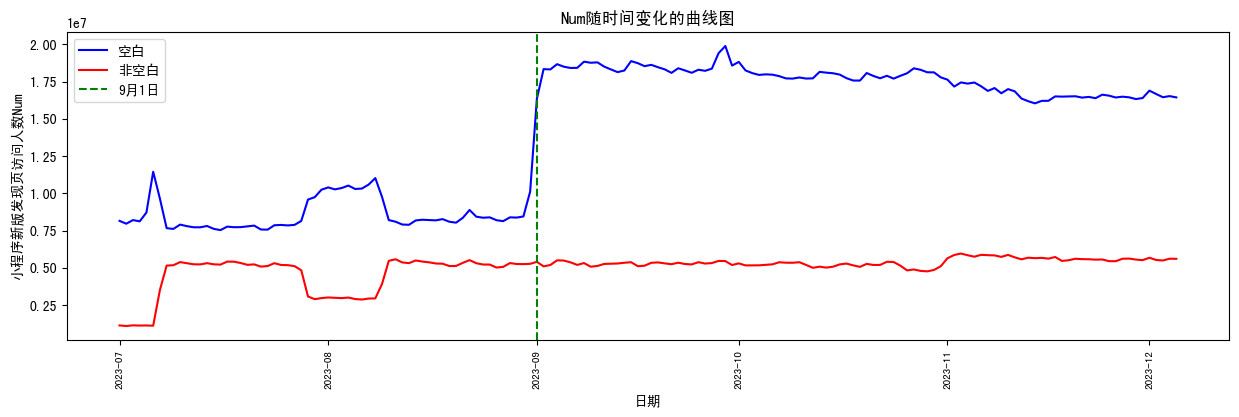

In [4]:
# 将 "ds" 列转换为 datetime 类型
df['ds'] = pd.to_datetime(df['ds'])

# 按照 "ds" 列对 DataFrame 进行排序
df.sort_values(by='ds', inplace=True)
# 根据 "label" 列分割数据
df_blank = df[df['label'] == '空白']
df_non_blank = df[df['label'] == '非空白']

# 设置图表大小（宽度，高度）
plt.figure(figsize=(15, 4))
# 绘制曲线图
plt.plot(df_blank['ds'], df_blank['num'], label='空白', color='blue')
plt.plot(df_non_blank['ds'], df_non_blank['num'], label='非空白', color='red')

# 设置图表标题和坐标轴标签
plt.title('Num随时间变化的曲线图')
plt.xlabel('日期')
plt.ylabel('小程序新版发现页访问人数Num')

# 设置日期刻度竖直显示
plt.xticks(rotation='vertical')
plt.tick_params(axis='x', labelsize=8)

# 绘制纵向虚线
sep_1 = pd.to_datetime('2023-09-01')  # 根据实际数据调整日期
plt.axvline(x=sep_1, linestyle='--', color='green', label='9月1日')
# 添加图例
plt.legend()

# 显示图表
plt.show()

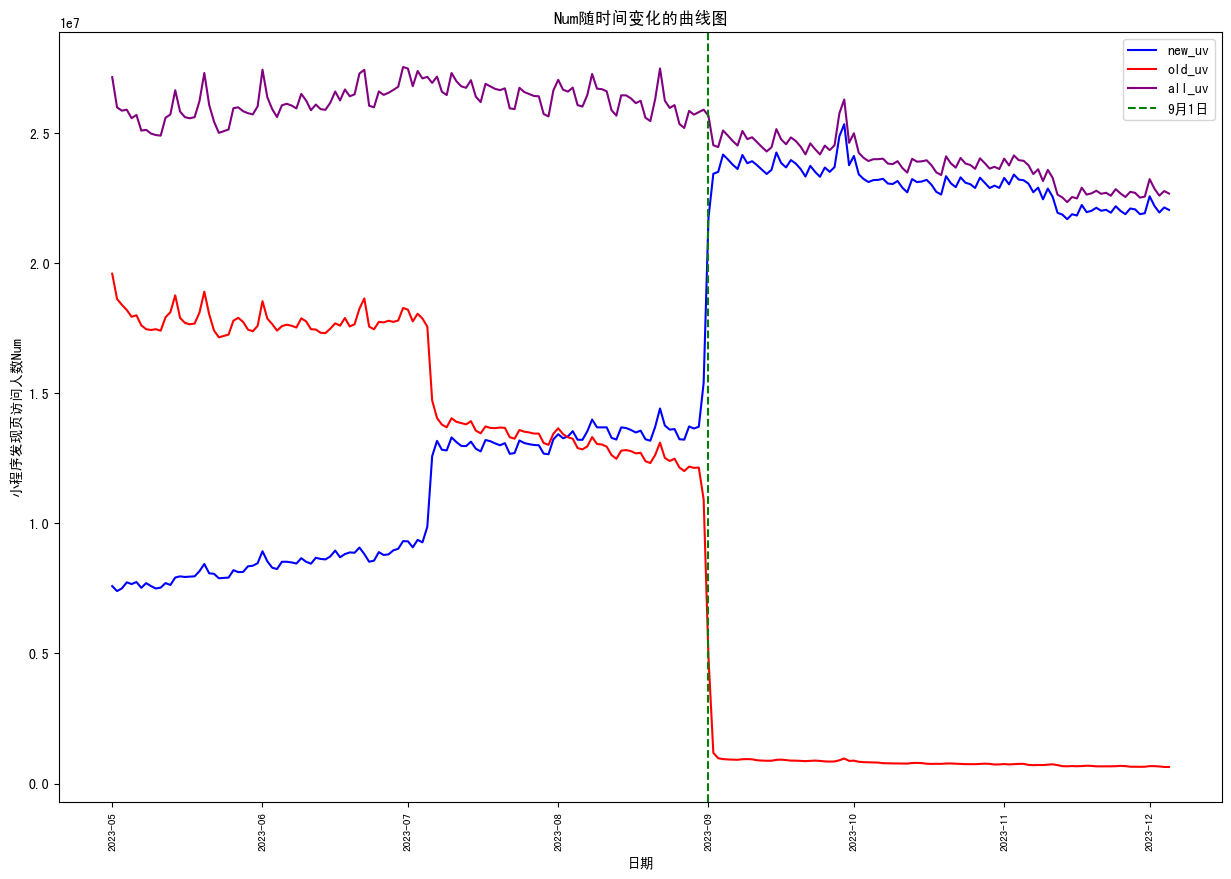

In [5]:
# 将 "ds" 列转换为 datetime 类型
df_all['ds'] = pd.to_datetime(df_all['ds'])
# 按照 "ds" 列对 DataFrame 进行排序
df_all.sort_values(by='ds', inplace=True)
# 根据 "label" 列分割数据

# 设置图表大小（宽度，高度）
plt.figure(figsize=(15, 10))
# 绘制曲线图
plt.plot(df_all['ds'], df_all['new_uv'], label='new_uv', color='blue')
plt.plot(df_all['ds'], df_all['old_uv'], label='old_uv', color='red')
plt.plot(df_all['ds'], df_all['all_uv'], label='all_uv', color='purple')

# 设置图表标题和坐标轴标签
plt.title('Num随时间变化的曲线图')
plt.xlabel('日期')
plt.ylabel('小程序发现页访问人数Num')

# 设置日期刻度竖直显示
plt.xticks(rotation='vertical')
plt.tick_params(axis='x', labelsize=8)
# 绘制纵向虚线
sep_1 = pd.to_datetime('2023-09-01')  # 根据实际数据调整日期
plt.axvline(x=sep_1, linestyle='--', color='green', label='9月1日')
# 添加图例
plt.legend()

# 显示图表
plt.show()

In [23]:
df_retention

,ds,second_scene_note,uv,pv,uv_pencent,pv_pencent
0,2023-09-01,None,5779675,46919075,1.000000,1.000000
26,2023-09-01,外部APP,10642,35371,0.001841,0.000754
17,2023-09-01,支付功能,137182,213952,0.023735,0.004560
1,2023-09-01,发现,5776153,11704753,0.999391,0.249467
2,2023-09-01,发现 - 小程序,2395512,9525955,0.414472,0.203029
...,...,...,...,...,...,...
3418,2023-12-04,企业微信,6918,21286,0.001997,0.000837
3419,2023-12-04,搜索广告,4550,5620,0.001313,0.000221
3413,2023-12-04,外部APP,11318,35578,0.003267,0.001400
3414,2023-12-04,其他广告,12854,28784,0.003710,0.001132


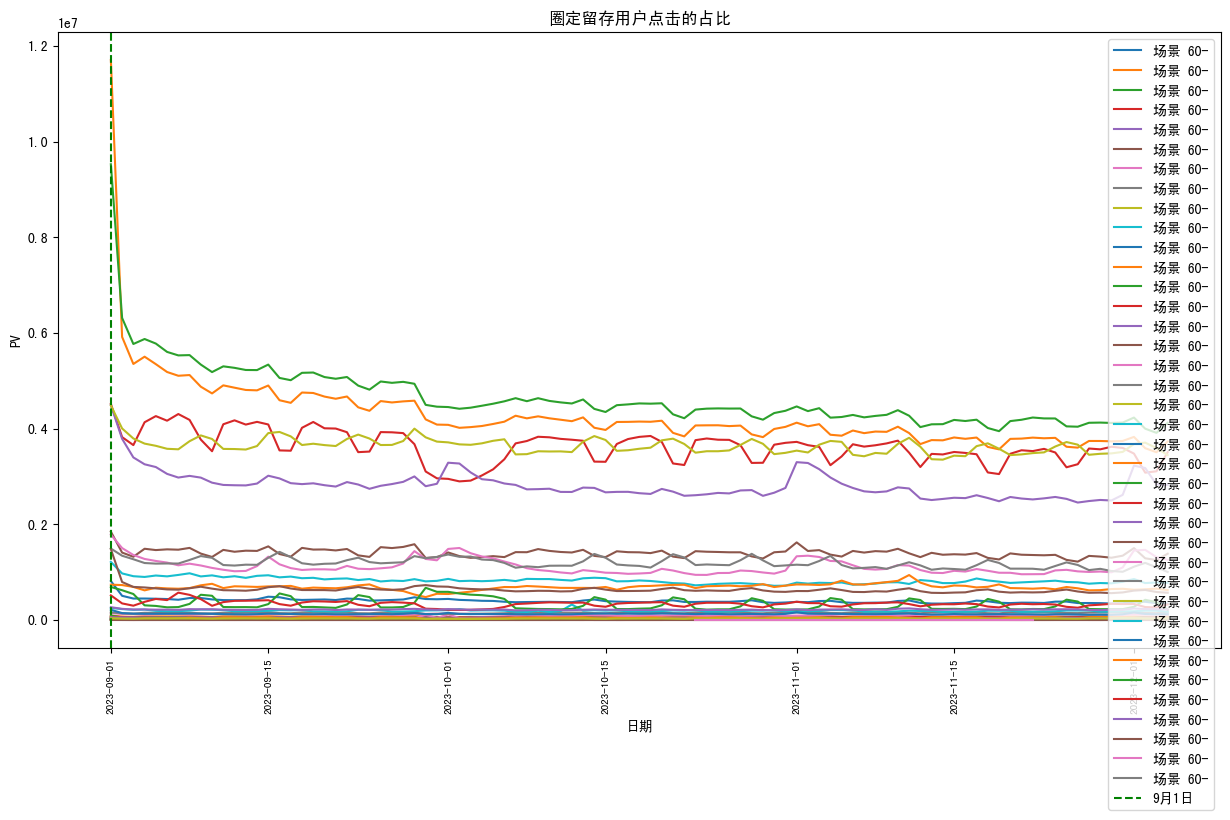

In [43]:
# 将 "ds" 列转换为 datetime 类型
df_retention['ds'] = pd.to_datetime(df_retention['ds'])
#df_retention['percentage'] = df_retention['percentage'].str.rstrip('%').astype(float) / 100

# 按照 "ds" 列对 DataFrame 进行排序
df_retention.sort_values(by='ds', inplace=True)
# 根据 "second_scene_note" 列分割数据
second_scene_notes = df_retention['second_scene_note'].unique()

# 设置图表大小（宽度，高度）
plt.figure(figsize=(15, 8))

# 为每个 age_label 值绘制曲线图
for second_scene_note in second_scene_notes:
    # 过滤 DataFrame 以仅包含当前 age_label 的行
    df_filtered = df_retention[df_retention['second_scene_note'] == second_scene_note]
    
    # 绘制曲线图
    plt.plot(df_filtered['ds'], df_filtered['pv'], label=f'场景 {age_label}')

# 设置图表标题和坐标轴标签
plt.title('圈定留存用户点击的占比')
plt.xlabel('日期')
plt.ylabel('PV')

# 设置日期刻度竖直显示
plt.xticks(rotation='vertical')
plt.tick_params(axis='x', labelsize=8)

# 绘制纵向虚线
#sep_1 = pd.to_datetime('2023-09-01')  # 根据实际数据调整日期
plt.axvline(x=sep_1, linestyle='--', color='green', label='9月1日')
# 添加图例
plt.legend()

# 显示图表
plt.show()

In [73]:
# 将 "ds" 列转换为 datetime 类型
df_retention_age['ds'] = pd.to_datetime(df_retention_age['ds'])


# 按照 "ds" 列对 DataFrame 进行排序
df_retention_age.sort_values(by='ds', inplace=True)
df_retention_age.loc[(df_retention_age['age_label'].isnull()) & (df_retention_age['uv'] > 1000000), 'age_label'] = '全部'
df_retention_age[df_retention_age['ds']=='2023-09-05']

,ds,age_label,uv,pv,uv_percnt,pv_percnt
396,2023-09-05,全部,3769054,31011342,1.000000,1.000000
397,2023-09-05,20-40,1846811,15636613,0.489993,0.504222
398,2023-09-05,40-60,1449936,11930318,0.384695,0.384708
399,2023-09-05,0-20,251169,1717312,0.066640,0.055377
400,2023-09-05,60-,208646,1609718,0.055358,0.051907
401,2023-09-05,None,12492,117381,0.003314,0.003785


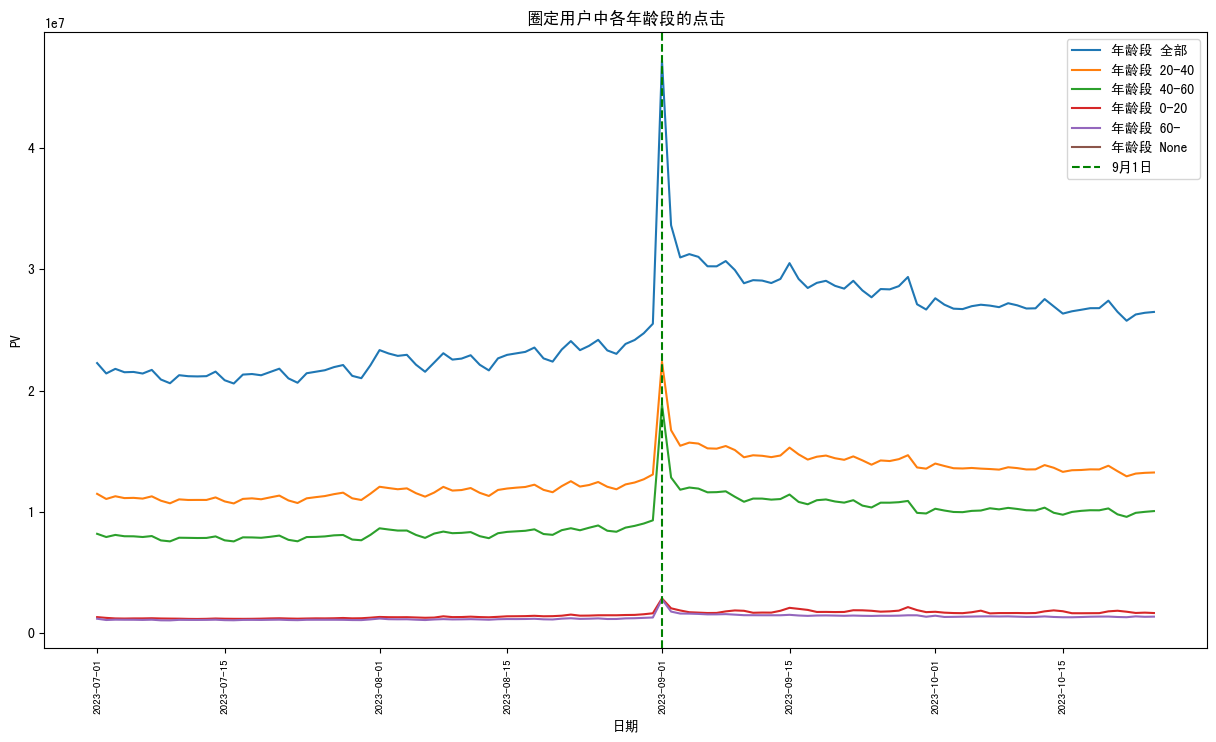

In [74]:

# 根据 "age_label" 列分割数据
age_labels = df_retention_age['age_label'].unique()

# 设置图表大小（宽度，高度）
plt.figure(figsize=(15, 8))

# 为每个 age_label 值绘制曲线图
for age_label in age_labels:
    # 过滤 DataFrame 以仅包含当前 age_label 的行
    df_filtered = df_retention_age[df_retention_age['age_label'] == age_label]
    
    # 绘制曲线图
    plt.plot(df_filtered['ds'], df_filtered['pv'], label=f'年龄段 {age_label}')

# 设置图表标题和坐标轴标签
plt.title('圈定用户中各年龄段的点击')
plt.xlabel('日期')
plt.ylabel('PV')


# 设置日期刻度竖直显示
plt.xticks(rotation='vertical')
plt.tick_params(axis='x', labelsize=8)

# 绘制纵向虚线
#sep_1 = pd.to_datetime('2023-09-01')  # 根据实际数据调整日期
plt.axvline(x=sep_1, linestyle='--', color='green', label='9月1日')
# 添加图例
plt.legend()

# 显示图表
plt.show()

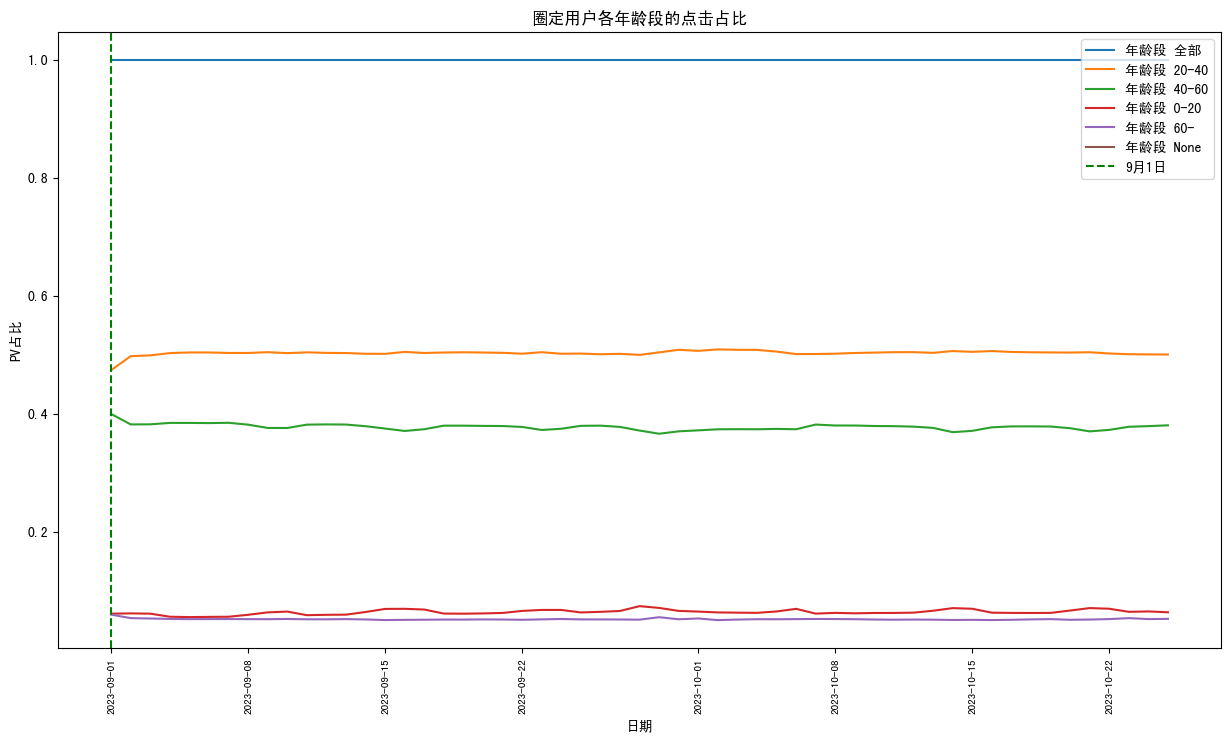

In [63]:
# 设置图表大小（宽度，高度）
plt.figure(figsize=(15, 8))

# 为每个 age_label 值绘制曲线图
for age_label in age_labels:
    # 过滤 DataFrame 以仅包含当前 age_label 的行
    df_filtered = df_retention_age[df_retention_age['age_label'] == age_label]
    
    # 绘制曲线图
    plt.plot(df_filtered['ds'], df_filtered['pv_percnt'], label=f'年龄段 {age_label}')

# 设置图表标题和坐标轴标签
plt.title('圈定用户各年龄段的点击占比')
plt.xlabel('日期')
plt.ylabel('PV占比')


# 设置日期刻度竖直显示
plt.xticks(rotation='vertical')
plt.tick_params(axis='x', labelsize=8)

# 绘制纵向虚线
#sep_1 = pd.to_datetime('2023-09-01')  # 根据实际数据调整日期
plt.axvline(x=sep_1, linestyle='--', color='green', label='9月1日')
# 添加图例
plt.legend()

# 显示图表
plt.show()

In [75]:
import numpy as np
from scipy.stats import ttest_ind

# 假设您有两组样本数据：sample1 和 sample2
sample1 = np.array([0.55,0.62,0.47,0.52,0.45,0.37,0.55])
sample2 = np.array([1.15,1.30,1.10,1.25,1.12,1.11,1.33])

# 进行双样本 T 检验
t_stat, p_value = ttest_ind(sample1, sample2)

# 设置显著水平
alpha = 0.05

# 判断 p_value 是否小于显著水平
if p_value < alpha:
    print("拒绝原假设，两组样本存在显著差异。")
else:
    print("不能拒绝原假设，两组样本不存在显著差异。")

# 打印 T 统计量和 p 值
print("T 统计量:", t_stat)
print("p 值:", p_value)

拒绝原假设，两组样本存在显著差异。
T 统计量: -14.421659045634419
p 值: 6.087741074301382e-09
